In [225]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
import warnings
pd.set_option('display.max_columns',None)
pd.options.display.float_format='{:.3f}'.format
warnings.filterwarnings('ignore')

In [199]:
data = pd.read_csv('ShopeeData.csv')

In [200]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3867 entries, 0 to 3866
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   itemid               3867 non-null   int64  
 1   shopid               3867 non-null   int64  
 2   liked_count          3867 non-null   int64  
 3   cmt_count            3867 non-null   int64  
 4   discount             3842 non-null   object 
 5   shop_location        3867 non-null   object 
 6   shop_rating          3867 non-null   float64
 7   name                 3867 non-null   object 
 8   historical_sold      3867 non-null   int64  
 9   price                3867 non-null   float64
 10  rating_star          3867 non-null   float64
 11  rating_count         3867 non-null   int64  
 12  rcount_with_context  3867 non-null   int64  
 13  status               3867 non-null   object 
 14  Date                 3867 non-null   object 
dtypes: float64(3), int64(7), object(5)
mem

Trong tất cả các cột thì có các cột 'discount', 'shop_location', 'name', 'status' và 'Date' kiểu object, nên em sẽ xử lý những cột này

Cột Discount có giá trị null và theo em xem qua dữ liệu thì những ô không có giá trị thì em nghĩ là nó không có giảm giá nên em sẽ fill vào là '0%' và chuẩn hoá lại kiểu dữ liệu integer

In [201]:
data['discount'].fillna('0%', inplace=True)
data['discount'] = data['discount'].str.replace('%', '').astype(int)

In [202]:
data['status'].value_counts()

status
normal    3867
Name: count, dtype: int64

In [203]:
data['shop_location'].value_counts()

shop_location
HÃ  Ná»™i    3867
Name: count, dtype: int64

In [204]:
data['name'].value_counts()

name
Sá»¯a Rá»­a Máº·t CeraVe SA Smoothing, Hydrating, Foaming Cleanser - Cho Da Dáº§u Má»¥n, KhÃ´, Nháº¡y Cáº£m 88ml â€“ 236ml â€“ 473ml    22
NÆ°á»›c Táº©y Trang L'Oreal Paris 3in1 Micellar Water 95ml - 400ml, LÃ m Sáº¡ch, DÆ°á»¡ng áº¨m Cho Má»i Loáº¡i Da Loreal               22
Sá»¯a Rá»­a Máº·t Giáº£m Má»¥n Ngá»«a Khuáº©n - Ziaja Med Anti Imperfections Formula Cleansing Gel 200ml                                22
Kem DÆ°á»¡ng SVR SEBIACLEAR Active Gel 40ml, LÃ m Giáº£m Má»¥n VÃ  GiÃºp Loáº¡i Bá» Dáº§u Cho Da                                       22
Kem Giáº£m Má»¥n vÃ  Nhá»n Eucerin Pro Acne A.I Clearing Treatment 40ml - Má» Váº¿t ThÃ¢m, TÃ¡i Táº¡o Da, Tinh Cháº¥t                 22
                                                                                                                                        ..
Xá»‹t DÆ°á»¡ng CÃ¢n Báº±ng Da Ziaja Manuka Tree Purifying Astringent Face Toner 200ml - GiÃºp Se KhÃ­t Lá»— ChÃ¢n LÃ´ng                  4
Sá»¯a Rá»­a Máº·t Ziaj

### Ở đây, 2 cột 'status' và 'shop_location' đều có một giá trị không đổi, và cột 'name' thì sẽ tương ứng với cột 'itemid' khi mà truy xuất muốn biết là vật phẩm gì thì có thể xem id của nó thì sẽ truy xuất được. 

### Sau đó, em sẽ chuẩn hoá lại cột 'Date' cho đúng định dạng ngày/tháng

In [205]:
data['Date'] = pd.to_datetime(data['Date'])
data['day'] = data['Date'].dt.day

In [206]:
data['shopid'].value_counts()

shopid
18363975    3867
Name: count, dtype: int64

### Tiếp theo là loại bỏ những cột không cần thiết

In [207]:
data = data.drop(columns=['shop_location', 'name', 'status', 'shopid'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3867 entries, 0 to 3866
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   itemid               3867 non-null   int64         
 1   liked_count          3867 non-null   int64         
 2   cmt_count            3867 non-null   int64         
 3   discount             3867 non-null   int64         
 4   shop_rating          3867 non-null   float64       
 5   historical_sold      3867 non-null   int64         
 6   price                3867 non-null   float64       
 7   rating_star          3867 non-null   float64       
 8   rating_count         3867 non-null   int64         
 9   rcount_with_context  3867 non-null   int64         
 10  Date                 3867 non-null   datetime64[ns]
 11  day                  3867 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(7)
memory usage: 347.6 KB


## Mô tả bài toán
Theo yêu cầu là dự đoán số lượng sản phẩm sẽ được bán ra vào ngày hôm sau thì em chọn cách là sẽ dự đoán số lượng bán ra dựa vào cột 'historical_sold'

Theo bộ dữ liệu em đọc và phân tích thì theo cách hiểu của em là cột 'historical_sold' số lượng sản phẩm đã bán được của một ngày cụ thể theo một sản phẩm cụ thể. 

Thì em sẽ dự đoán dự đoán số lượng sẽ bán được tiếp theo dựa vào 'historical_sold'

### Bước đầu tiên là lấy ra được số lượng đã bán của một sản phẩm trong một ngày

In [208]:
data_sorted = data.sort_values(by=['itemid', 'Date'])

# Sử dụng groupby để nhóm dữ liệu theo 'itemid'
grouped = data_sorted.groupby('itemid')

# Tính toán sự khác biệt giữa các giá trị 'historical_sold' của các ngày liên tiếp
data_sorted['num_sold'] = grouped['historical_sold'].diff()

data_sorted['num_sold'] = data_sorted['num_sold'].fillna(method='bfill')

In [209]:
data_sorted.sort_index(inplace=True)
data_sorted.head()

,itemid,liked_count,cmt_count,discount,shop_rating,historical_sold,price,rating_star,rating_count,rcount_with_context,Date,day,num_sold
0,20030969576,25677,9675,11,4.931,35701,9200000000.000,4.907,9675,5639,2024-03-10,10,60.000
1,19527695224,20032,6504,40,4.931,23141,6600000000.000,4.922,6504,4034,2024-03-10,10,79.000
2,21407947288,18760,2611,4,4.931,8489,11500000000.000,4.933,2611,1441,2024-03-10,10,10.000
3,14185378989,14582,8600,47,4.931,28022,7900000000.000,4.923,8602,5430,2024-03-10,10,102.000
4,10001549800,29919,19065,22,4.931,69948,10900000000.000,4.916,19068,10715,2024-03-10,10,159.000


In [210]:
df = data_sorted.drop(columns=['Date', 'historical_sold'])

In [211]:
data_train_to_29 = df[df['day'] < 30]
data_test_to_29 = df[df['day'] >= 30]

In [212]:
data_day_30 = df[df['day'] == 30]

In [213]:
x_train = data_train_to_29.drop(columns=['num_sold'])
y_train = data_train_to_29['num_sold']

x_test = data_test_to_29.drop(columns=['num_sold'])
y_test = data_test_to_29['num_sold']

In [214]:
def model(x_train, y_train, x_test, y_test):
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(x_train, y_train)
    y_pred_rf = model_rf.predict(x_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)

    model_e = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model_e.fit(x_train, y_train)
    y_pred_e = model_e.predict(x_test)
    mse_e = mean_squared_error(y_test, y_pred_e)

    model_b = BaggingRegressor(n_estimators=10, random_state=0)
    model_b.fit(x_train, y_train)
    y_pred_b = model_b.predict(x_test)
    mse_b = mean_squared_error(y_test, y_pred_b)

    model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.12005)
    model_xgb.fit(x_train, y_train)
    y_pred_xgb = model_xgb.predict(x_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)

    model_name = ['Random Forest', 'Gradient Boosting', 'Bagging', 'XGBoost']
    mse = [mse_rf, mse_e, mse_b, mse_xgb]
    score = [model_rf.score(x_test, y_test), model_e.score(x_test, y_test), model_b.score(x_test, y_test), model_xgb.score(x_test, y_test)]
    dataframe = pd.DataFrame({'Model': model_name, 'MSE': mse, 'Score': score})
    return dataframe

# Dự đoán ngày 30

In [215]:
model(x_train, y_train, data_day_30.drop(columns=['num_sold']), data_day_30['num_sold'])

,Model,MSE,Score
0,Random Forest,96.496,0.955
1,Gradient Boosting,110.767,0.948
2,Bagging,87.325,0.959
3,XGBoost,87.450,0.959


## Dự đoán 2 ngày gồm ngày 30 và 31

In [216]:
model(x_train, y_train, x_test, y_test)

,Model,MSE,Score
0,Random Forest,70.482,0.955
1,Gradient Boosting,96.946,0.939
2,Bagging,67.584,0.957
3,XGBoost,70.311,0.955


## Lấy dữ liệu đến ngày 30 để dự đoán cho ngày 31

In [217]:
x_train = df[df['day'] < 31].drop(columns=['num_sold'])
y_train = df[df['day'] < 31]['num_sold']

x_test = df[df['day'] == 31].drop(columns=['num_sold'])
y_test = df[df['day'] == 31]['num_sold']

In [218]:
model(x_train, y_train, x_test, y_test)

,Model,MSE,Score
0,Random Forest,36.967,0.963
1,Gradient Boosting,53.970,0.946
2,Bagging,52.782,0.947
3,XGBoost,59.730,0.940


### Kết quả mô hình dự đoán Random Forest cho sự sai số thấp nhất, có nghĩa là sự chênh lệch về số lượng sản phẩm sẽ được bán thực tế và dự đoán có sự chênh lệch thấp nhất trong các mô hình còn lại.

### So sánh chênh lệch

In [219]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict(x_test)

model_e = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_e.fit(x_train, y_train)
y_pred_e = model_e.predict(x_test)

model_b = BaggingRegressor(n_estimators=10, random_state=0)
model_b.fit(x_train, y_train)
y_pred_b = model_b.predict(x_test)

model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.12005)
model_xgb.fit(x_train, y_train)
y_pred_xgb = model_xgb.predict(x_test)

In [279]:
compare = pd.DataFrame({'itemid': x_test['itemid'], 
                        'Actual': y_test, 
                        'Random Forest': y_pred_rf, 
                        'Gradient Boosting': y_pred_e, 
                        'Bagging': y_pred_b, 
                        'XGBoost': y_pred_xgb})

compare.reset_index(drop=True, inplace=True)
compare.to_excel('Compare value of models.xlsx', index=False)

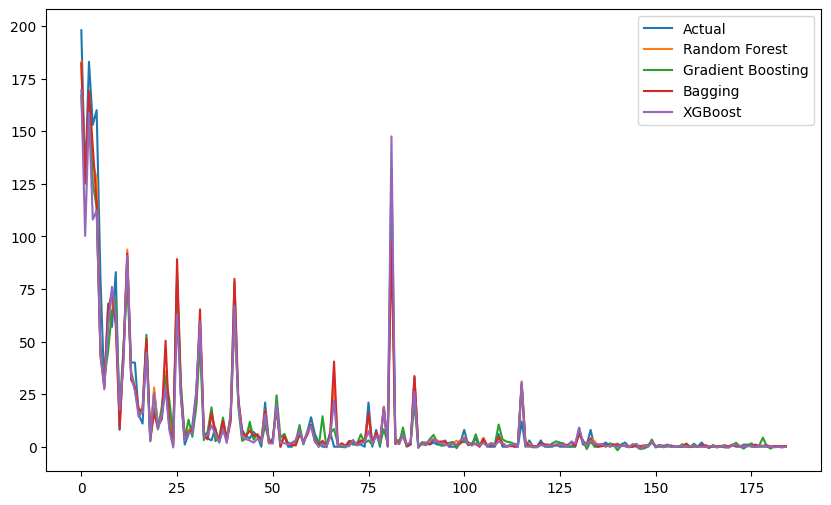

In [255]:
plt.figure(figsize=(10, 6))

plt.plot(compare['Actual'], label='Actual')

plt.plot(compare['Random Forest'], label='Random Forest')

plt.plot(compare['Gradient Boosting'], label='Gradient Boosting')

plt.plot(compare['Bagging'], label='Bagging')

plt.plot(compare['XGBoost'], label='XGBoost')

plt.legend()
plt.show()

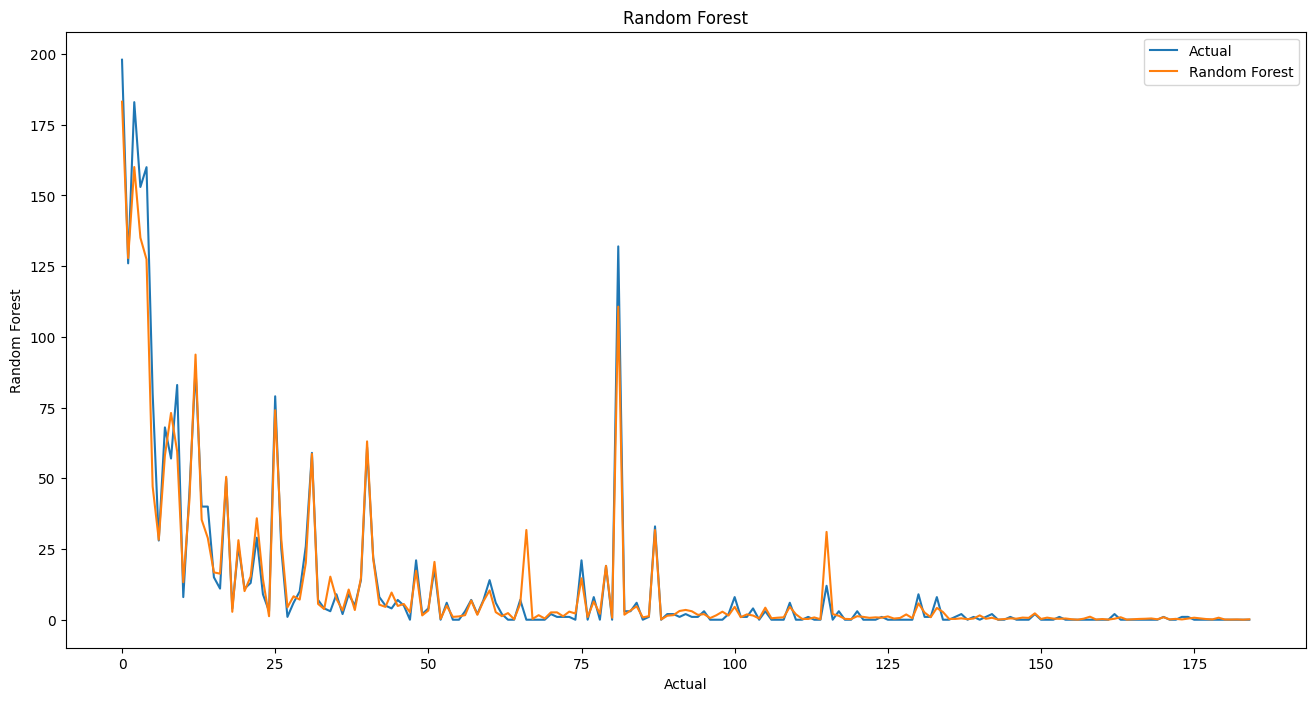

In [274]:
plt.figure(figsize=(16, 8))
plt.plot(compare['Actual'], label='Actual')
plt.plot(compare['Random Forest'], label='Random Forest')
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Random Forest')
plt.legend()
plt.show()

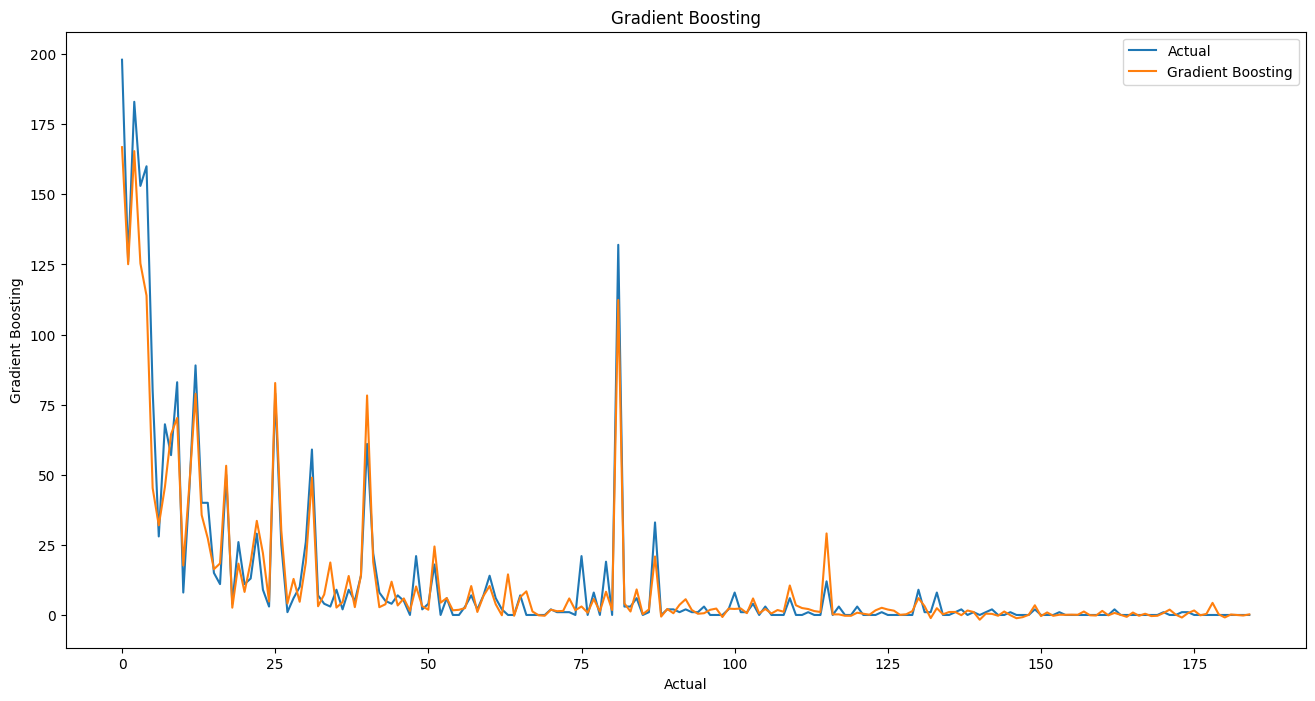

In [275]:
plt.figure(figsize=(16, 8))
plt.plot(compare['Actual'], label='Actual')
plt.plot(compare['Gradient Boosting'], label='Gradient Boosting')
plt.title('Gradient Boosting')
plt.xlabel('Actual')
plt.ylabel('Gradient Boosting')
plt.legend()
plt.show()

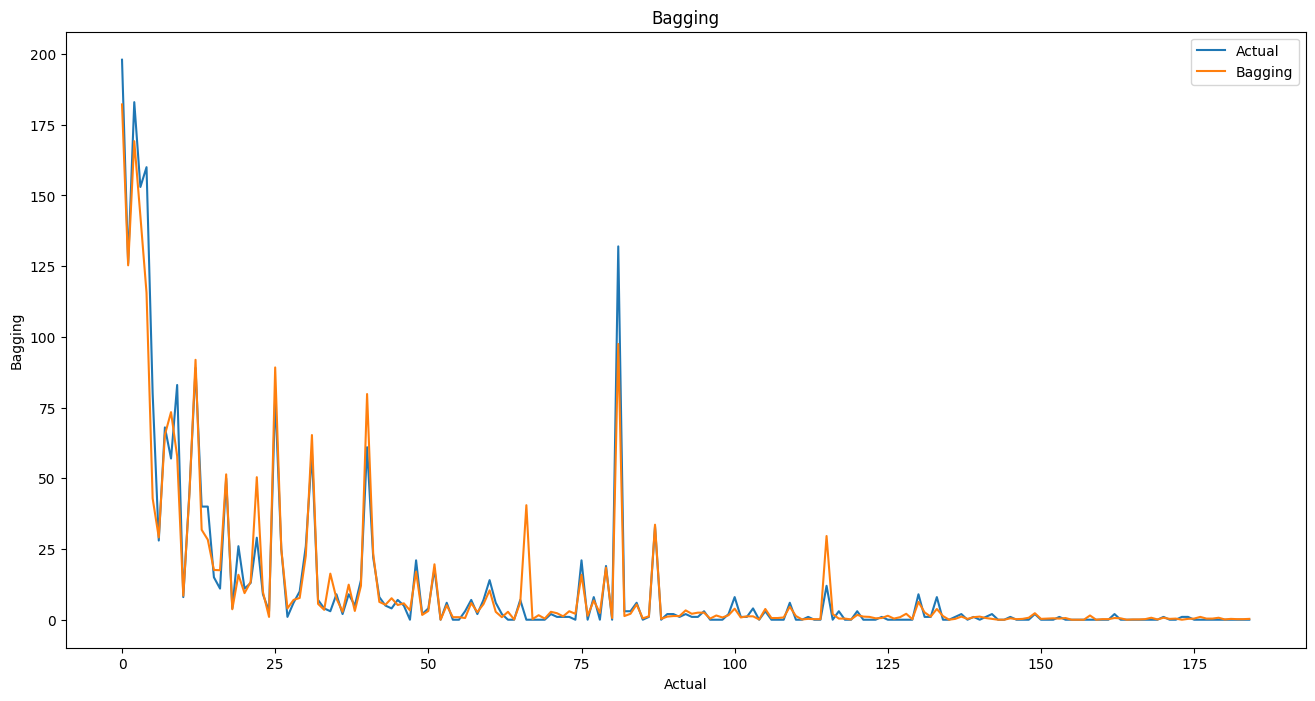

In [276]:
plt.figure(figsize=(16, 8))
plt.plot(compare['Actual'], label='Actual')
plt.plot(compare['Bagging'], label='Bagging')
plt.title('Bagging')
plt.xlabel('Actual')
plt.ylabel('Bagging')
plt.legend()
plt.show()

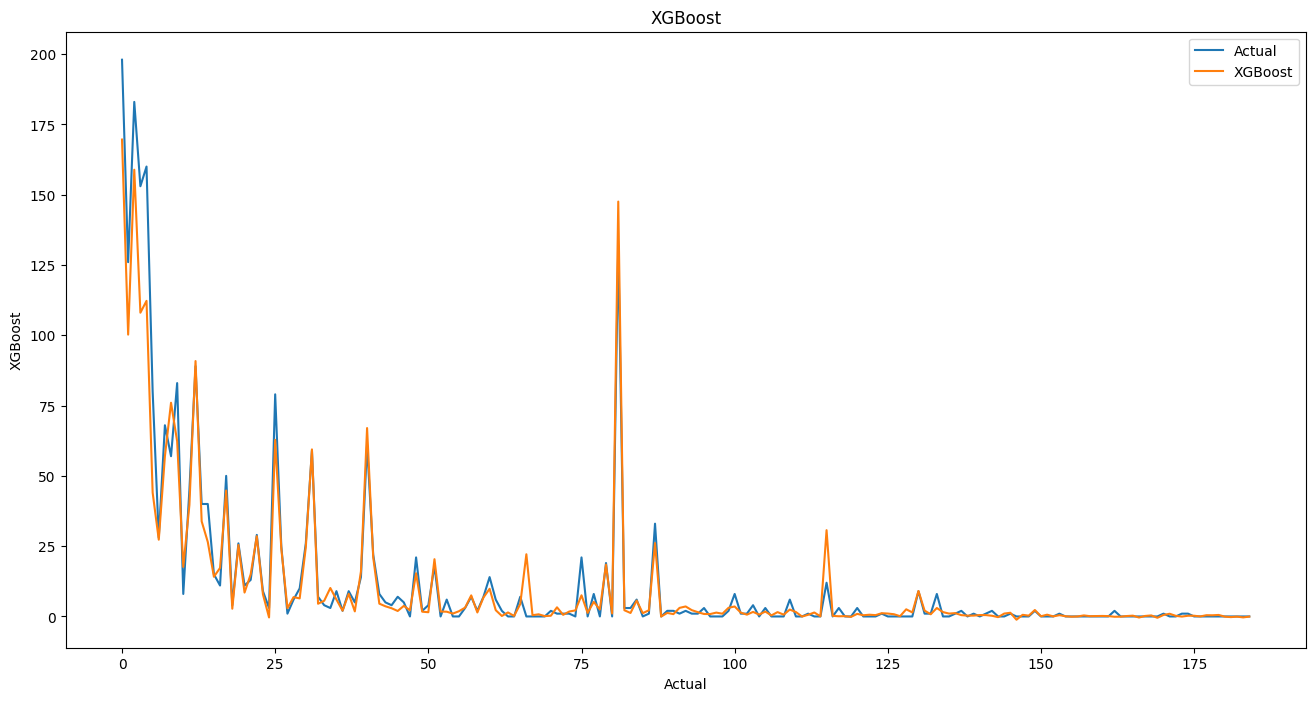

In [277]:
plt.figure(figsize=(16, 8))
plt.plot(compare['Actual'], label='Actual')
plt.plot(compare['XGBoost'], label='XGBoost')
plt.title('XGBoost')
plt.xlabel('Actual')
plt.ylabel('XGBoost')
plt.legend()
plt.show()

Đây là file notebook em rút trích tóm gọn để tiến hành xây dựng mô hình để dự đoán số lượng sản phẩm theo mô hình Machine Learning. 

Trong quá trình phân tích dữ liệu thì em nghĩ bài toán này sẽ là phát triển theo hướng time series forecasting. Và em có train thử tập dữ liệu theo mô hình LSTM. Tuy nhiên hiện tại thì hàm loss(file loss.png) của mô hình vẫn còn khá cao nên em sẽ không đem mô hình này vào để nộp bài. Em nghĩ nguyên nhân là dữ liệu còn ít và em tiền xử lý dữ liệu chưa được tốt.

Em cảm ơn anh chị đã dành thời gian để đọc bài của em.